# CNN-TL |  Using TRANSFER LEARNING

In [88]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn theme to the plots
sns.set()

## UNSW-NB15-Train-Basic for training and UNSW-NB15-Test+ for validation

In [42]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [43]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [44]:
x_train.shape

(410556, 24, 1, 1)

In [45]:
# Load UNSW-NB15-Test+
data = pd.read_csv('../datasets/UNSW-NB15-Test+.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [46]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Generate 2 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(21, 'state_PAR', auxCol, True)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [47]:
x_test.shape

(55052, 24, 1, 1)

## Load Pretrained Model
Loading pretrained model from BoT-IoT and freeze convolutional base

In [48]:
# Load model of BoT-IoT Dataset
pre_trained_model = load_model('../models/BoT-IoT_CNN_Detection_Best.hdf5')

In [49]:
# Setting all layers to non trainable
pre_trained_model.trainable=False

In [50]:
# Removing the last 3 layers to get only the convolutional base
pre_trained_model.pop()
pre_trained_model.pop()
pre_trained_model.pop()

In [51]:
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 1, 32)         352       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 1, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 1, 64)         20544     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 1, 64)         0         
Total params: 20,896
Trainable params: 0
Non-trainable params: 20,896
_________________________________________________________________


## Transfer Learning
Creating the new model and training

In [52]:
# New model building
modelFE = models.Sequential()
modelFE.add(pre_trained_model)

modelFE.add(layers.Flatten())
modelFE.add(Dense(448, activation='relu'))
modelFE.add(layers.Dropout(0.4))
modelFE.add(Dense(224, activation='relu'))
modelFE.add(layers.Dropout(0.3))
modelFE.add(Dense(112, activation='relu'))
modelFE.add(layers.Dropout(0.3))
modelFE.add(Dense(2, activation='softmax'))

In [53]:
# Model summary
modelFE.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 24, 1, 64)         20896     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 448)               688576    
_________________________________________________________________
dropout_6 (Dropout)          (None, 448)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 224)               100576    
_________________________________________________________________
dropout_7 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 112)              

In [54]:
# Early Stopping

filepath = '../models/tmp/TransferLearning_Detection.hdf5' # define where the model is saved
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 2 # Stop after 5 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [ ]:
#Configure model training
modelFE.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = modelFE.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15,  batch_size=2048, callbacks=callbacks)

## Loading Best model from Transfer Learning
Load and validate the final transfer learning model

In [55]:
# Load Transfer Learning model
modelFE = load_model('../models/TransferLearning_Detection_Best.hdf5')

In [56]:
#Evaluate the model
results = modelFE.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.04845095053315163, 0.9904453754425049]


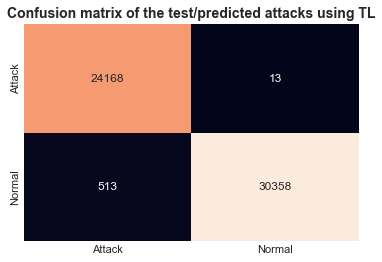

In [57]:
# Prediction
predicted = modelFE.predict(x_test)

# Confusion matrix
y_class = np.argmax(predicted, axis = 1)
y_test1=y_test
y_test1=y_test1.to_numpy()
y_check = np.argmax(y_test1, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)

cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix of the test/predicted attacks using TL', weight='bold', fontsize=14)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
plt.show()

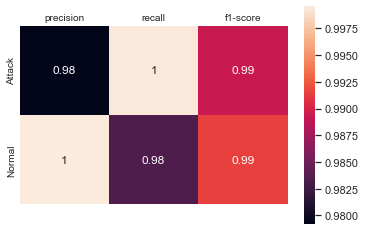

In [58]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [59]:
class_rep

{'Attack': {'precision': 0.9792147806004619,
  'recall': 0.999462387825152,
  'f1-score': 0.9892349883344931,
  'support': 24181},
 'Normal': {'precision': 0.9995719600935102,
  'recall': 0.9833824625052638,
  'f1-score': 0.9914111230854642,
  'support': 30871},
 'accuracy': 0.9904453970791252,
 'macro avg': {'precision': 0.989393370346986,
  'recall': 0.991422425165208,
  'f1-score': 0.9903230557099787,
  'support': 55052},
 'weighted avg': {'precision': 0.9906302875417156,
  'recall': 0.9904453970791252,
  'f1-score': 0.99045527925757,
  'support': 55052}}

## Analysing Attack Detection

### Code

In [60]:
predicted

array([[9.6973932e-01, 3.0260701e-02],
       [9.6813631e-01, 3.1863641e-02],
       [9.5895910e-01, 4.1040875e-02],
       ...,
       [6.4985768e-05, 9.9993503e-01],
       [8.4363208e-05, 9.9991560e-01],
       [3.6288056e-04, 9.9963713e-01]], dtype=float32)

In [61]:
df = pd.DataFrame(predicted)
df.index = data.index

In [62]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [63]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [64]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [65]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

In [66]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']


In [67]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

In [68]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.66 % of NO detected and 98.34 % of detected samples


In [69]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [70]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [71]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 0.05 % of NO detected and 99.95 % of detected samples


In [72]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 0.07 % of NO detected and 99.93 % of detected samples


In [73]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 1.15 % of NO detected and 98.85 % of detected samples


In [74]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0]})

In [75]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [76]:
data_plot=dff[['category', 'category_pred']]

In [77]:
data_plot

,category,category_pred
4,fuzzers,Detected
5,fuzzers,Detected
6,fuzzers,Detected
7,fuzzers,Detected
8,fuzzers,Detected
...,...,...
61869,normal,Detected
61870,normal,Detected
61871,normal,Detected
61872,normal,Detected


### Results

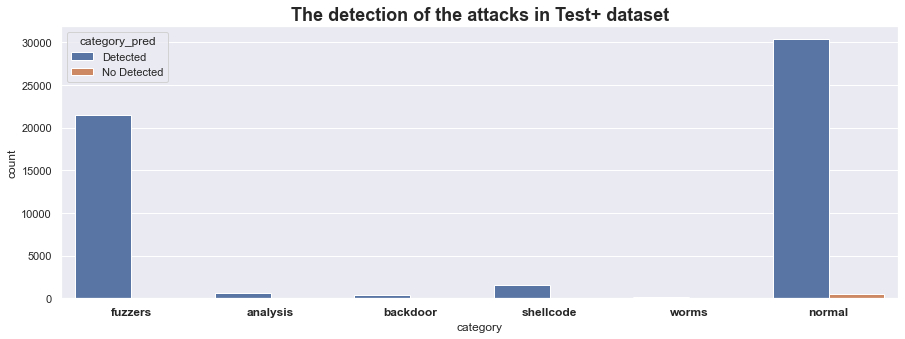

In [78]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [79]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.338246,1.661754,30358,513
1,Analysis,100.000000,0.000000,622,0
2,Backdoor,100.000000,0.000000,357,0
3,Fuzzers,99.953525,0.046475,21507,10
4,Shellcode,99.933819,0.066181,1510,1
5,Worms,98.850575,1.149425,172,2


## UNSW-NB15-Train-Basic for training and UNSW-NB15-Test for validation

In [80]:
# Load UNSW-NB15-Test+
data = pd.read_csv('../datasets/UNSW-NB15-Test.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [81]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].replace('-', -1)
data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [82]:
x_test.shape

(2495843, 24, 1, 1)

In [83]:
# Load Transfer Learning model
modelFE = load_model('../models/TransferLearning_Detection_Best.hdf5')

In [84]:
#Evaluate the model
results = modelFE.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.08837240934371948, 0.9788908958435059]


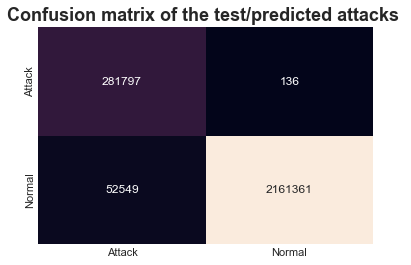

In [85]:
# Prediction
predicted = modelFE.predict(x_test)

# Confusion matrix
y_class = np.argmax(predicted, axis = 1)
y_test1=y_test
y_test1=y_test1.to_numpy()
y_check = np.argmax(y_test1, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)

cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
plt.show()

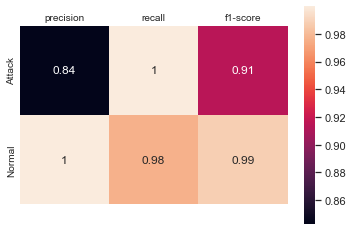

In [86]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [89]:
# Precision, Recall & F1-Score
FPR, TPR, THRESHOLD = metrics.roc_curve(y_check, y_class)

In [90]:
FPR[1]

0.0004823841125373759

In [91]:
class_rep

{'Attack': {'precision': 0.8428304809987258,
  'recall': 0.9995176158874626,
  'f1-score': 0.9145111223974856,
  'support': 281933},
 'Normal': {'precision': 0.9999370806436465,
  'recall': 0.976264166113347,
  'f1-score': 0.9879588344581429,
  'support': 2213910},
 'accuracy': 0.9788908997881678,
 'macro avg': {'precision': 0.9213837808211862,
  'recall': 0.9878908910004047,
  'f1-score': 0.9512349784278142,
  'support': 2495843},
 'weighted avg': {'precision': 0.9821901570760616,
  'recall': 0.9788908997881678,
  'f1-score': 0.9796621051348652,
  'support': 2495843}}

## Analysing Attack Detection

### Code

In [92]:
predicted

array([[8.8871337e-02, 9.1112858e-01],
       [9.5390514e-02, 9.0460944e-01],
       [3.8764698e-03, 9.9612349e-01],
       ...,
       [2.4601141e-02, 9.7539890e-01],
       [4.8684957e-05, 9.9995136e-01],
       [6.9881588e-01, 3.0118412e-01]], dtype=float32)

In [93]:
df = pd.DataFrame(predicted)
df.index = data.index

In [94]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [95]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [96]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [97]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

generic=df.loc[df['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df.loc[df['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df.loc[df['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df.loc[df['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [98]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [99]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [100]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 2.37 % of NO detected and 97.63 % of detected samples


In [101]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [102]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [103]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 0.13 % of NO detected and 99.87 % of detected samples


In [104]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 0.07 % of NO detected and 99.93 % of detected samples


In [105]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 1.15 % of NO detected and 98.85 % of detected samples


In [106]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.02 % of NO detected and 99.98 % of detected samples


In [107]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 0.18 % of NO detected and 99.82 % of detected samples


In [108]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.02 % of NO detected and 99.98 % of detected samples


In [109]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 0.49 % of NO detected and 99.51 % of detected samples


In [110]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [111]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [112]:
data_plot=dff[['category', 'category_pred']]

In [113]:
data_plot

,category,category_pred
0,normal,Detected
1,normal,Detected
2,normal,Detected
3,normal,Detected
4,normal,Detected
...,...,...
2540042,normal,Detected
2540043,normal,Detected
2540044,normal,Detected
2540045,normal,Detected


### Results

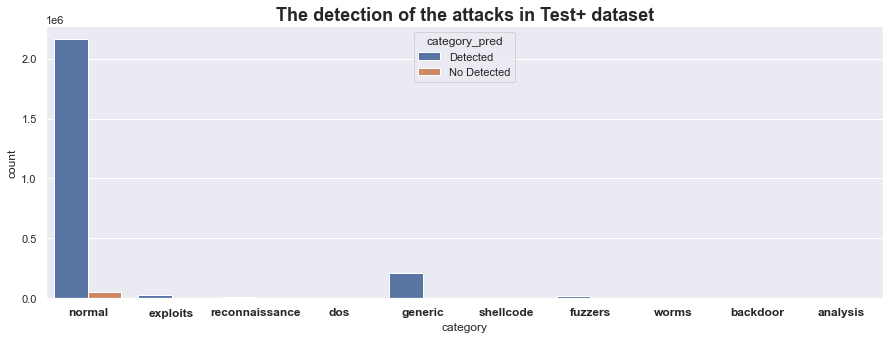

In [114]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [115]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,97.626417,2.373583,2161361,52549
1,Analysis,100.000000,0.000000,622,0
2,Backdoor,100.000000,0.000000,357,0
3,Fuzzers,99.869870,0.130130,21489,28
4,Shellcode,99.933819,0.066181,1510,1
5,Worms,98.850575,1.149425,172,2
6,Generic,99.984559,0.015441,213685,33
7,Exploits,99.819896,0.180104,28266,51
8,Reconnaissance,99.983128,0.016872,11852,2
9,DoS,99.508154,0.491846,3844,19
